In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from functools import reduce

# pmdarima kütüphanesi otomatik ARIMA modelleri için
from pmdarima import auto_arima

In [2]:
df_master = pd.read_csv('main_df.csv')

In [ ]:
df_master

### children am usage kaldırılmalı bence

In [3]:
country_name = 'Germany'

In [13]:
df_country = df_master[df_master['Entity']== country_name].copy()

In [14]:
df_country

,Entity,Year,A,O,R,W,Total_DDD,Access_pct,Watch_pct,Reserve_pct,Other_pct,am_consumption_rate,am_usage_children,is_glass_country,antimicrobial_aqua_law,antimicrobial_livestock_law,livestock_am_sales,e_coli_ARM_percent,s_aureus_ARM_percent
1200,Germany,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1818.91500,NaN,NaN
1201,Germany,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1707.95950,NaN,NaN
1202,Germany,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1531.92070,NaN,NaN
1203,Germany,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1305.91100,NaN,NaN
1204,Germany,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,853.65560,NaN,NaN
1205,Germany,2016,1.772626e+08,6260104.0,489934.0,1.536503e+08,3.376630e+08,52.496916,45.504038,0.145096,1.853950,13.062739,NaN,NaN,NaN,NaN,779.44275,11.56,10.30
1206,Germany,2017,1.846938e+08,6336673.0,500331.0,1.436172e+08,3.351481e+08,55.108130,42.851875,0.149287,1.890708,12.791286,NaN,NaN,NaN,NaN,766.77890,12.28,9.10
1207,Germany,2018,1.782374e+08,6364007.0,484757.0,1.286158e+08,3.137020e+08,56.817431,40.999362,0.154528,2.028679,11.954763,NaN,NaN,NaN,NaN,753.07623,12.18,7.60
1208,Germany,2019,1.857320e+08,6458398.0,483970.0,1.139156e+08,3.065899e+08,60.579926,37.155692,0.157856,2.106526,11.657459,NaN,NaN,NaN,NaN,654.52484,11.46,6.80
1209,Germany,2020,1.562453e+08,6282369.0,496293.0,8.025635e+07,2.432803e+08,64.224385,32.989256,0.204001,2.582359,9.261937,NaN,NaN,NaN,NaN,684.59340,10.20,5.58


## 2000-2024 arası oluşturduk öncesinde temizlik yapmak mantıklı olabilir çok boş satır var

In [15]:
# --- 2. Yıl Sütununu Zaman İndeksi Yapma ---
# Zaman serisi analizi için 'Year' sütununu datetime'a çevirip index yapmalıyız
df_country['Year'] = pd.to_datetime(df_country['Year'], format='%Y')
df_country = df_country.set_index('Year')

In [7]:
# --- 3. Kategorik Veriyi Sayısala Çevirme (One-Hot Encoding) ---
# 'livestock_law_status' (Yes/No/Neither) sütununu modelin anlayacağı 0/1'lere çevirelim
df_country = pd.get_dummies(df_country, columns=['antimicrobial_livestock_law'], drop_first=True, dtype=int)

In [16]:
df_country

,Entity,A,O,R,W,Total_DDD,Access_pct,Watch_pct,Reserve_pct,Other_pct,am_consumption_rate,am_usage_children,is_glass_country,antimicrobial_aqua_law,antimicrobial_livestock_law,livestock_am_sales,e_coli_ARM_percent,s_aureus_ARM_percent
Year,,,,,,,,,,,,,,,,,,
2011-01-01,Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1818.91500,NaN,NaN
2012-01-01,Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1707.95950,NaN,NaN
2013-01-01,Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1531.92070,NaN,NaN
2014-01-01,Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1305.91100,NaN,NaN
2015-01-01,Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,853.65560,NaN,NaN
2016-01-01,Germany,1.772626e+08,6260104.0,489934.0,1.536503e+08,3.376630e+08,52.496916,45.504038,0.145096,1.853950,13.062739,NaN,NaN,NaN,NaN,779.44275,11.56,10.30
2017-01-01,Germany,1.846938e+08,6336673.0,500331.0,1.436172e+08,3.351481e+08,55.108130,42.851875,0.149287,1.890708,12.791286,NaN,NaN,NaN,NaN,766.77890,12.28,9.10
2018-01-01,Germany,1.782374e+08,6364007.0,484757.0,1.286158e+08,3.137020e+08,56.817431,40.999362,0.154528,2.028679,11.954763,NaN,NaN,NaN,NaN,753.07623,12.18,7.60
2019-01-01,Germany,1.857320e+08,6458398.0,483970.0,1.139156e+08,3.065899e+08,60.579926,37.155692,0.157856,2.106526,11.657459,NaN,NaN,NaN,NaN,654.52484,11.46,6.80


### Belki bu true-false gibi değerlerden ülkeleri kümelere bölebiliriz

In [ ]:




# --- 4. Eksik Verileri Doldurma (Interpolasyon) ---
# Tahminleme modelleri NaN (boş) değerlerle çalışamaz.
# Yıllar arasındaki boşlukları 'lineer interpolasyon' ile dolduracağız.
# (İki bilinen nokta arasına düz bir çizgi çekerek aradaki boşluğu doldurur)

# Veri setini en baştan en sona kadar tüm yılları içerecek şekilde yeniden indeksle
# Bu, 2016-2023 arası eksik yıllar varsa onları da oluşturur
min_year = df_country.index.min().year
# 2024 verisi olduğunu varsayarak (yoksa son yılı alır)
max_year = max(df_country.index.max().year, 2024) 

full_year_index = pd.date_range(start=f'{min_year}-01-01', end=f'{max_year}-01-01', freq='AS-JAN') # Yıl başı

df_country = df_country.reindex(full_year_index)

# Lineer interpolasyon yap
df_country_interpolated = df_country.interpolate(method='linear', limit_direction='both')

# Başta/sonda hala NaN varsa (genelde olur), en yakın değerle doldur (bfill/ffill)
df_country_interpolated = df_country_interpolated.ffill().bfill()

# 'Entity' sütunu artık gereksiz, interpolasyondan sonra 'nan' olduysa atalım
df_country_interpolated = df_country_interpolated.drop(columns=['Entity'], errors='ignore')

print(f"--- {country_name} için Veri Hazırlandı (2024'e kadar dolduruldu) ---")
print(df_country_interpolated)

--- Germany için Veri Hazırlandı (2024'e kadar dolduruldu) ---
                       A          O          R             W     Total_DDD  \
2011-01-01  1.772626e+08  6260104.0   489934.0  1.536503e+08  3.376630e+08   
2012-01-01  1.772626e+08  6260104.0   489934.0  1.536503e+08  3.376630e+08   
2013-01-01  1.772626e+08  6260104.0   489934.0  1.536503e+08  3.376630e+08   
2014-01-01  1.772626e+08  6260104.0   489934.0  1.536503e+08  3.376630e+08   
2015-01-01  1.772626e+08  6260104.0   489934.0  1.536503e+08  3.376630e+08   
2016-01-01  1.772626e+08  6260104.0   489934.0  1.536503e+08  3.376630e+08   
2017-01-01  1.846938e+08  6336673.0   500331.0  1.436172e+08  3.351481e+08   
2018-01-01  1.782374e+08  6364007.0   484757.0  1.286158e+08  3.137020e+08   
2019-01-01  1.857320e+08  6458398.0   483970.0  1.139156e+08  3.065899e+08   
2020-01-01  1.562453e+08  6282369.0   496293.0  8.025635e+07  2.432803e+08   
2021-01-01  1.466141e+08  5679316.0   438739.0  6.865737e+07  2.213895e+08   
2

/var/folders/x8/dq97svx144d4vz2gmpy__lcr0000gn/T/ipykernel_1298/2112141246.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_country_interpolated = df_country.interpolate(method='linear', limit_direction='both')


## Seçtiğimiz ülke için 2030 tahminleri

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho


--- AutoARIMA Temel Model (Baseline) Eğitiliyor... ---
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=22.938, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=24.870, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=24.837, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=20.938, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.290 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   14
Model:               SARIMAX(0, 2, 0)   Log Likelihood                  -9.469
Date:                Tue, 28 Oct 2025   AIC                             20.938
Time:                        18:39:05   BIC                             21.423
Sample:                    01-01-2011   HQIC                            20.758
                         - 01-01-

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

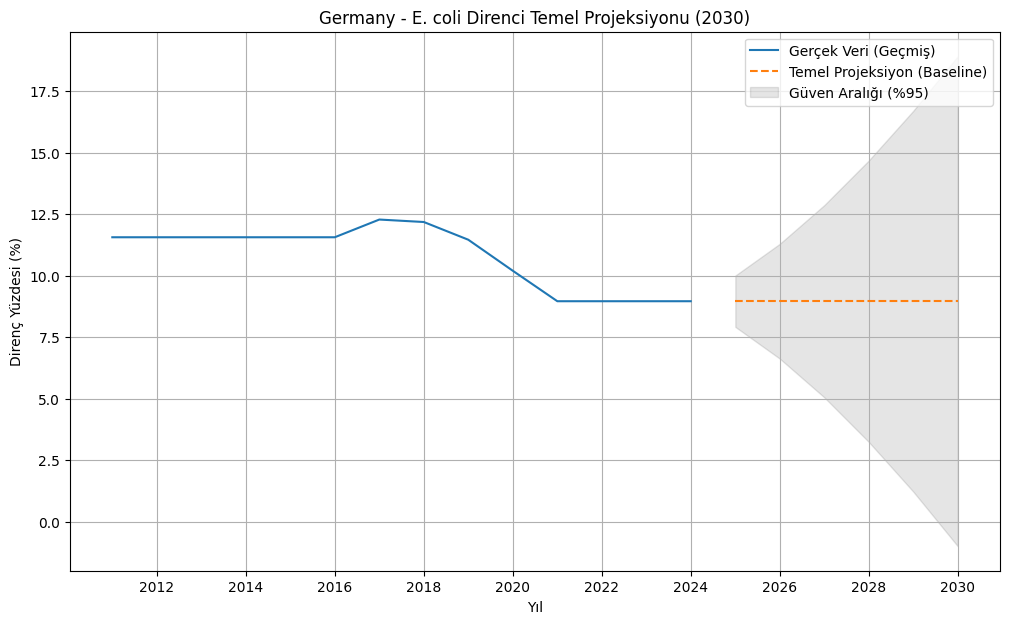

In [10]:
# --- 1. Modelin Kurulması (auto_arima) ---
# Sadece 'e_coli_ARM_percent' sütununu kullanarak (mevcut trend neyse)
# bir temel model oluşturalım.

print("\n--- AutoARIMA Temel Model (Baseline) Eğitiliyor... ---")

# Hedef değişkenimiz (y)
y_baseline = df_country_interpolated['e_coli_ARM_percent']

# 'm=1' mevsimsellik olmadığını belirtir (yıllık veride)
baseline_model = auto_arima(
    y_baseline,
    start_p=1, start_q=1,
    test='adf',       # Verinin durağan olup olmadığını test et
    max_p=3, max_q=3, # Maksimum p ve q değerleri
    m=1,              # Mevsimsellik periyodu (yıllık veri için 1)
    d=None,           # d değerini otomatik bulsun
    seasonal=False,   # Mevsimsellik yok
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
)

print(baseline_model.summary())

# --- 2. 2030'a Kadar Tahminleme ---
# 2024 (son veri yılı) sonrası 6 yıl = 2030
n_periods_future = 2030 - df_country_interpolated.index.max().year

baseline_forecast, conf_int = baseline_model.predict(
    n_periods=n_periods_future, 
    return_conf_int=True, 
    alpha=0.05 # %95 güven aralığı
)

# Tahmin sonuçlarını bir DataFrame'e dönüştür
forecast_index = pd.date_range(
    start=df_country_interpolated.index.max() + pd.DateOffset(years=1), 
    periods=n_periods_future, 
    freq='AS-JAN'
)
baseline_forecast_df = pd.DataFrame(baseline_forecast, index=forecast_index, columns=['Prediction'])
conf_int_df = pd.DataFrame(conf_int, index=forecast_index, columns=['Lower CI', 'Upper CI'])

print(f"\n--- 2030'a Kadar Temel Projeksiyon ({country_name}) ---")
print(baseline_forecast_df)

# --- 3. Görselleştirme ---
plt.figure(figsize=(12, 7))
plt.plot(y_baseline.index, y_baseline, label='Gerçek Veri (Geçmiş)')
plt.plot(baseline_forecast_df.index, baseline_forecast_df['Prediction'], label='Temel Projeksiyon (Baseline)', linestyle='--')
plt.fill_between(baseline_forecast_df.index, 
                 conf_int_df['Lower CI'], 
                 conf_int_df['Upper CI'], 
                 color='k', 
                 alpha=0.1, 
                 label='Güven Aralığı (%95)')
plt.title(f"{country_name} - E. coli Direnci Temel Projeksiyonu (2030)")
plt.xlabel('Yıl')
plt.ylabel('Direnç Yüzdesi (%)')
plt.legend()
plt.grid(True)
plt.show()


--- Simülasyon Modeli (ARIMAX) Eğitiliyor... ---
Kullanılan parametreler (X): ['A', 'O', 'R', 'W', 'Total_DDD', 'Access_pct', 'Watch_pct', 'Reserve_pct', 'Other_pct', 'am_consumption_rate', 'am_usage_children', 'is_glass_country', 'antimicrobial_aqua_law', 'livestock_am_sales']
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=22.938, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=24.870, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=24.837, Time=0.02 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

 ARIMA(0,2,0)(0,0,0)[0]             : AIC=20.938, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.223 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   14
Model:               SARIMAX(0, 2, 0)   Log Likelihood                  -9.469
Date:                Tue, 28 Oct 2025   AIC                             20.938
Time:                        18:39:06   BIC                             21.423
Sample:                    01-01-2011   HQIC                            20.758
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2837      0.105      2.703      0.007       0.078   

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


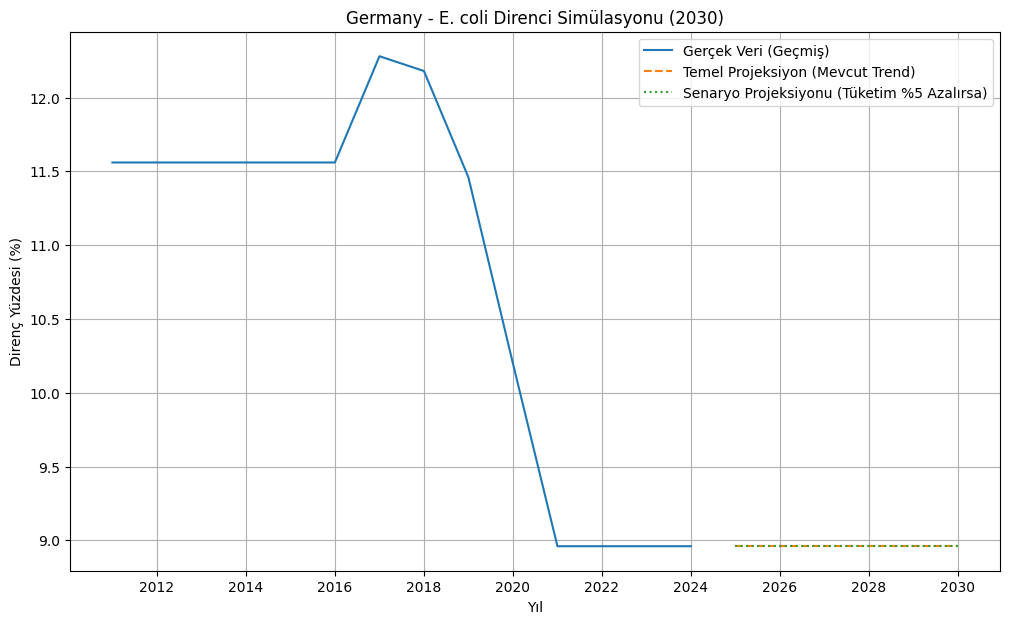

In [11]:
# --- 1. Simülasyon için Harici Parametreleri (X) Tanımlama ---
# Modelimize "E. coli direncini etkileyen diğer faktörler şunlardır" diyeceğiz.

# 'e_coli_ARM_percent' (tahmin hedefimiz - y)
y_train = df_country_interpolated['e_coli_ARM_percent']

# Diğer tüm sütunlar (parametrelerimiz - X)
# 's_aureus' direncini de hedef olarak görebileceğimiz için X'ten çıkaralım.
X_train = df_country_interpolated.drop(columns=['e_coli_ARM_percent', 's_aureus_ARM_percent'], errors='ignore')

print("\n--- Simülasyon Modeli (ARIMAX) Eğitiliyor... ---")
print("Kullanılan parametreler (X):", X_train.columns.tolist())

# --- 2. ARIMAX Modelini Eğitme ---
# Bu sefer 'X' (exogenous) parametresini de modele veriyoruz
simulation_model = auto_arima(
    y_train,
    exogenous=X_train,
    start_p=1, start_q=1,
    test='adf',
    max_p=3, max_q=3,
    m=1,
    d=None,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(simulation_model.summary())

# --- 3. Simülasyon Senaryosu Oluşturma (2025-2030) ---
# BU EN ÖNEMLİ KISIM:
# Modele "2025-2030 arası parametreler (X) şöyle olacak" demeliyiz.

# Senaryo X (X_future) DataFrame'ini oluşturalım
X_future = pd.DataFrame(index=forecast_index, columns=X_train.columns)

# ** SENARYO: Tüketim (total_consumption_did) Her Yıl %5 Azalırsa **

# 2024'teki son tüketim değeri
last_consumption = X_train['Total_DDD'].iloc[-1]

# Gelecek yılların tüketim değerlerini hesapla (her yıl %5 azalma)
future_consumption = []
current_val = last_consumption
for _ in range(n_periods_future):
    current_val *= 0.95 # %5 azalt
    future_consumption.append(current_val)
    
X_future['Total_DDD'] = future_consumption

# ** Diğer parametreler (örn: yasa) sabit kalsın (son değer neyse o) **
for col in X_future.columns:
    if col != 'Total_DDD':
        X_future[col] = X_train[col].iloc[-1] # Son bilinen değeri tekrarla

print("\n--- Gelecek Senaryosu (X_future) ---")
print(X_future)

# --- 4. Simülasyonu Çalıştırma ve Tahminleme ---

simulation_forecast, sim_conf_int = simulation_model.predict(
    n_periods=n_periods_future,
    exogenous=X_future,
    return_conf_int=True,
    alpha=0.05
)

simulation_forecast_df = pd.DataFrame(simulation_forecast, index=forecast_index, columns=['Scenario_Prediction'])

print("\n--- Senaryo Projeksiyonu (Simülasyon) ---")
print(simulation_forecast_df)

# --- 5. İki Grafiği Karşılaştırma ---
plt.figure(figsize=(12, 7))
plt.plot(y_train.index, y_train, label='Gerçek Veri (Geçmiş)')

# Temel Model (Adım 4'ten)
plt.plot(baseline_forecast_df.index, baseline_forecast_df['Prediction'], label='Temel Projeksiyon (Mevcut Trend)', linestyle='--')

# Senaryo Modeli (Adım 5'ten)
plt.plot(simulation_forecast_df.index, simulation_forecast_df['Scenario_Prediction'], label='Senaryo Projeksiyonu (Tüketim %5 Azalırsa)', linestyle=':')

plt.title(f"{country_name} - E. coli Direnci Simülasyonu (2030)")
plt.xlabel('Yıl')
plt.ylabel('Direnç Yüzdesi (%)')
plt.legend()
plt.grid(True)
plt.show()